<a href="https://colab.research.google.com/github/stepthom/869_course/blob/main/2026%20869%20Project%20Template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMAI 869 Project: Example Notebook

*Updated May 1, 2025*

This notebook serves as a template for the Team Project. Teams can use this notebook as a starting point, and update it successively with new ideas and techniques to improve their model results.

Note that is not required to use this template. Teams may also alter this template in any way they see fit.

# Preliminaries: Inspect and Set up environment

No action is required on your part in this section. These cells print out helpful information about the environment, just in case.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report


In [2]:
import datetime
print(datetime.datetime.now())

2025-06-03 23:38:11.991945


In [3]:
!python3 --version

Python 3.10.16


In [4]:
# TODO: if you need to install any package, do so here. For example:
#pip install unidecode

# 0: Data Loading and Inspection

In [5]:
df = pd.read_csv("https://raw.githubusercontent.com/stepthom/869_course/refs/heads/main/data/spaceship_titanic_train.csv")

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [7]:
# Let's print some descriptive statistics for all the numeric features.

df.describe().T
# This gives that it is highly right-skewed for all numeric features apart from age
# The age distribution is right-skewed. The majority of passengers are young adults (20–30).
# The median is close to the mean, the skew isn't too extreme.

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,28.827930,14.489021,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,224.687617,666.717663,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.077203,1611.489240,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,173.729169,604.696458,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.138778,1136.705535,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,304.854791,1145.717189,0.0,0.0,0.0,46.0,24133.0


In [8]:
# Let's print some descriptive statistics for all the numeric features.

df.describe().T# What is the number of unique values in all the categorical features? And what is
# the value with the highest frequency?

df.describe(include=object).T
# can frop 'Name' feature
# looking at the dataset from cabin, can see whether or not passenger is solo or in a group. 

,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Gollux Reedall,2


In [9]:
# How much missing data is in each feature?

df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [10]:
# For convienience, let's save the names of all numeric features to a list,
# and the names of all categorical features to another list.

numeric_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

categorical_features = ['HomePlanet', 'VIP', 'CryoSleep', 'Destination', 'Cabin', 'Name']

RoomService     5577
FoodCourt       5456
ShoppingMall    5587
Spa             5324
VRDeck          5495
dtype: int64

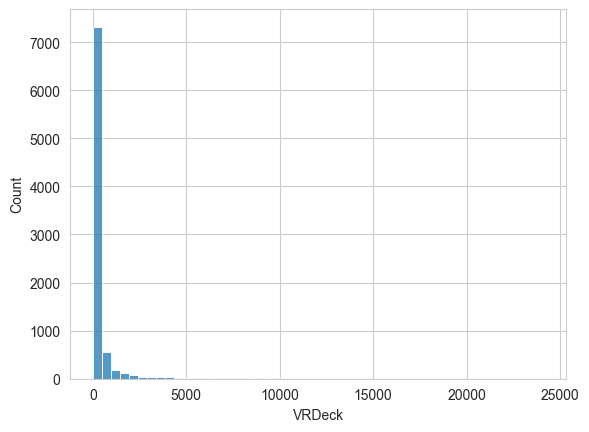

In [11]:
# TODO: Can add more EDA here, as desired
# Univariate data exploration
sns.histplot(df['VRDeck'], bins=50)
# highly rigt-skewed - check number of passenger with 0 spending 
columns_to_check_spend0 = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
(df[columns_to_check_spend0] == 0).sum()
# for all, more than half with 0 spending -> can think transfrom into binary variables, or combine them all together 

In [12]:
df['TotalSpend'] = df[columns_to_check_spend0].sum(axis=1)
(df['TotalSpend'] == 0).sum()
# almost half with 0 total spending, may use this in the model!

np.int64(3653)

<Axes: xlabel='Transported', ylabel='VRDeck'>

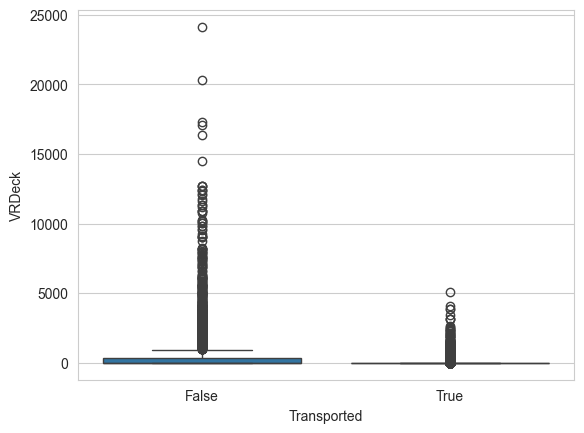

In [13]:
# Bivariate data exploration
# --- Numeric feature vs target (classification) 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'
sns.boxplot(x='Transported', y='VRDeck', data=df) 
# 'RoomService', 'Spa', 'VRDeck' -- Similar
# People who spent a lot on VRDeck were less likely to be transported.
# In contrast, low or zero spending is more common among those who were transported. -- support transform to binary variable
# sns.histplot(data=df, x='VRDeck', hue='Transported', kde=True, bins=50) 

In [14]:
# 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck'
#df['VRDeck_log'] = np.log1p(df['VRDeck'])  # log(1 + x) to avoid log(0)
#df['VRDeck_bin'] = pd.cut(df['VRDeck'], bins=[-0.1, 0, np.inf],
#                          labels=['Zero', 'Low'])
#sns.countplot(x='VRDeck_bin', hue='Transported', data=df)

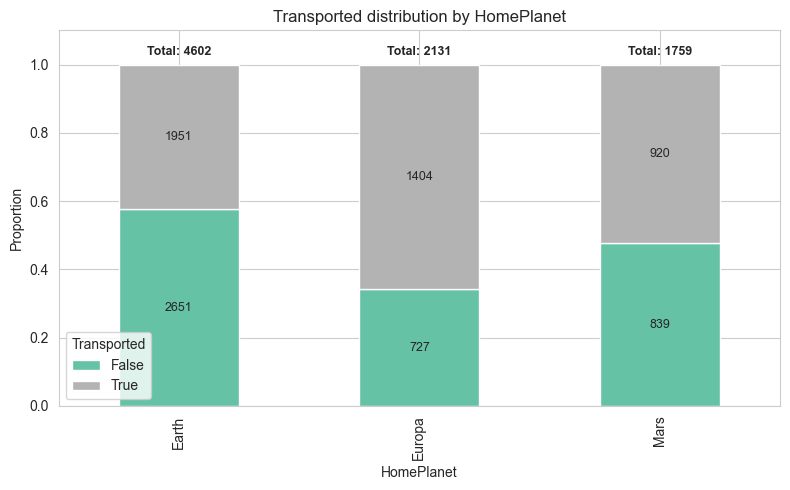

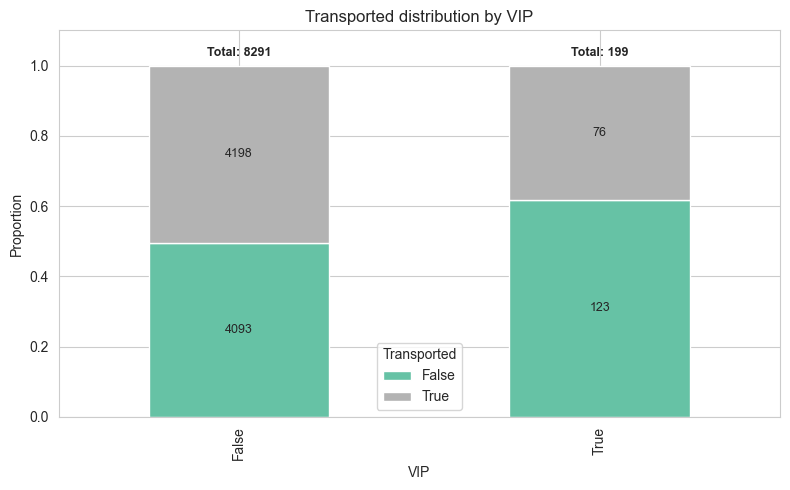

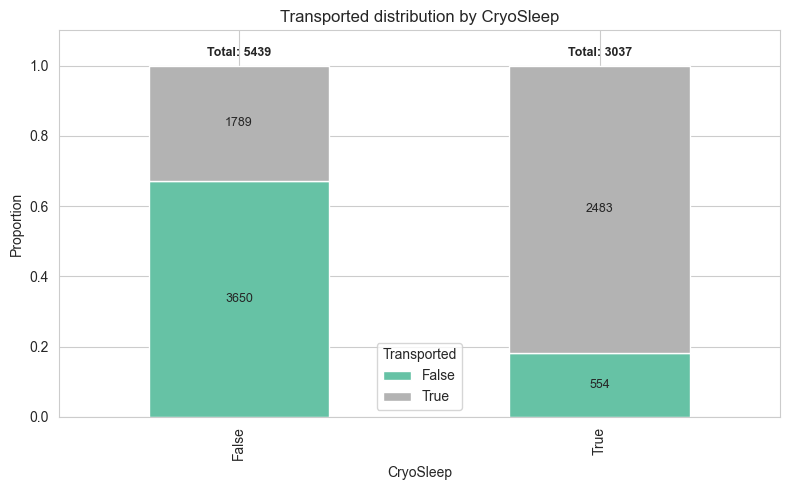

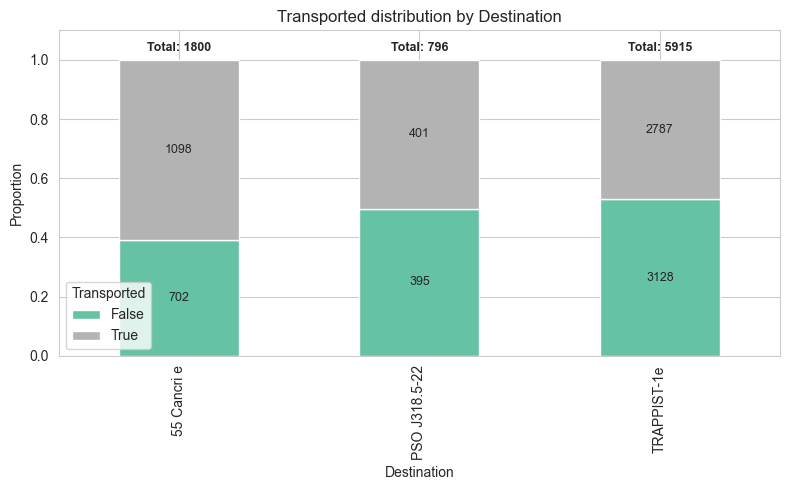

In [15]:
# --- Categorical feature vs target (classification)
target = 'Transported'

for col in categorical_features:
    if df[col].nunique() < 20:
        ct = pd.crosstab(df[col], df[target])             
        norm_ct = ct.div(ct.sum(axis=1), axis=0)         

        ax = norm_ct.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='Set2')

        for i, (index, row) in enumerate(ct.iterrows()):
            total = row.sum()
            bottom = 0
            for j, count in enumerate(row):
                height = count / total
                if count > 0:
                    ax.text(i, bottom + height / 2, str(count), ha='center', va='center', fontsize=9)
                bottom += height

            ax.text(i, 1.02, f'Total: {total}', ha='center', va='bottom', fontsize=9, fontweight='bold')

        plt.title(f'Transported distribution by {col}')
        plt.ylabel('Proportion')
        plt.xlabel(col)
        plt.ylim(0, 1.1)  # to make space for total label
        plt.legend(title='Transported')
        plt.tight_layout()
        plt.show()
# Passengers from Europa (~20% of population) are much more likely to be transported
# Being a VIP 'might' be negatively associated with being transported. -- as majority of passengers are NON-VIP -> may consider drop this
# Being in CryoSleep is strongly associated with a higher chance of being Transported.
# Destination has some predictive value, especially for distinguishing 55 Cancri e (~20% of population) but other ~0.5 -> may consider drop

# 1: Pipeline 1: Simple Feature Engineering and then Decision Tree

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

In [17]:
# Scikit-learn needs us to put the features in one dataframe, and the label in another.
# It's tradition to name these variables X and y, but it doesn't really matter.

X = df.drop(['PassengerId', 'Transported', 'Name'], axis=1)
y = df['Transported']

## 1.1: Cleaning and FE

In [12]:
# We know this dataset has categorical features, and we also know that DTs don't
# allow categorical features. For now, we'll just remove (i.e., drop) these
# features.
#
# TODO: do something better, like encode them (as discussed in the course)

#X = X.drop(categorical_features, axis=1, errors='ignore')
# need to fill in missing value first before encoding

In [13]:
# We know this dataset has some missing data, and we also know that DTs don't
# allow missing data. For now, we'll just do simple imputation.
#
# TODO: consider doing something different/better, like impute them (as
# discussed in class)

#imp = SimpleImputer()
#imp.fit(X)
#X = imp.transform(X)



In [31]:
# age -> mean
age_imputer = SimpleImputer(strategy='mean')
df['Age'] = age_imputer.fit_transform(df[['Age']])
# spending -> binary var
# category -> try both 1. fill in 'missing' category 2. use mode
# 1. fill in 'missing' category
for col in categorical_features:
    df[col] = df[col].fillna('Missing')

In [ ]:
# TODO: Add more data cleaning and FE, as desired.

In [32]:
# Numerical feature: Age - Binning Age into range and encoding
age_bins = [0, 12, 18, 30, 50, 80]
age_labels = ['Child', 'Teen', 'Young Adult', 'Adult', 'Senior']
df['AgeGroup'] = pd.cut(df['Age'], bins=age_bins, labels=age_labels, right=False)
df['AgeGroup_encoded'] = LabelEncoder().fit_transform(df['AgeGroup'])


In [33]:
# Numerical feature: spending - change it to binary variables 0 = no spending and 1 =spending
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend']
for col in spending_cols:
    df[col + '_Spent'] = (df[col] > 0).astype(int)

In [34]:
# Categorical feature: Cabin - identify whether travel as solo or in group
cabin_counts = df['Cabin'].value_counts()
df['Cabin_Count'] = df['Cabin'].map(cabin_counts)
df['SoloTraveler'] = (df['Cabin_Count'] == 1).astype(int)

In [35]:
# Categorical feature: encode
# df['CryoSleep'] = df['CryoSleep'].astype(int) --if fill mode
# df['VIP'] = df['VIP'].astype(int)--if fill mode
# ['HomePlanet', 'VIP', 'CryoSleep', 'Destination', 'Cabin', 'Name']
#le = LabelEncoder()
#for col in ['HomePlanet', 'VIP', 'CryoSleep', 'Destination', 'Cabin']:
#    df[col] = le.fit_transform(df[col].astype(str))
label_encoders = {}  # dictionary to store encoders

for col in ['HomePlanet', 'VIP', 'CryoSleep', 'Destination']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   PassengerId         8693 non-null   object  
 1   HomePlanet          8693 non-null   int64   
 2   CryoSleep           8693 non-null   int64   
 3   Cabin               8693 non-null   object  
 4   Destination         8693 non-null   int64   
 5   Age                 8693 non-null   float64 
 6   VIP                 8693 non-null   int64   
 7   RoomService         8512 non-null   float64 
 8   FoodCourt           8510 non-null   float64 
 9   ShoppingMall        8485 non-null   float64 
 10  Spa                 8510 non-null   float64 
 11  VRDeck              8505 non-null   float64 
 12  Name                8693 non-null   object  
 13  Transported         8693 non-null   bool    
 14  TotalSpend          8693 non-null   float64 
 15  AgeGroup            8693 non-null   ca

In [173]:
Drop_features = ['PassengerId',
                 #'HomePlanet',
                 #'CryoSleep',
                 'Cabin',
                 'Destination',
                 #'Age', 
                 'VIP',
                 'RoomService',
                 'FoodCourt',
                 'ShoppingMall',
                 'Spa',
                 'VRDeck',
                 'Name', 
                 'TotalSpend',
                 'AgeGroup',
                 'AgeGroup_encoded',
                 'RoomService_Spent',
                 'FoodCourt_Spent',
                 'ShoppingMall_Spent',
                 'Spa_Spent',
                 'VRDeck_Spent',
                 'TotalSpend_Spent',
                 'Cabin_Count',
                 #'SoloTraveler'
                ]
#0.7512054525137947
df_clean = df.drop(Drop_features, axis=1, errors='ignore')
df_clean.info()
X = df_clean.drop(['Transported'], axis=1)
y = df_clean['Transported']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    8693 non-null   int64  
 1   CryoSleep     8693 non-null   int64  
 2   Age           8693 non-null   float64
 3   Transported   8693 non-null   bool   
 4   SoloTraveler  8693 non-null   int64  
dtypes: bool(1), float64(1), int64(3)
memory usage: 280.3 KB


In [87]:
df_clean.head(10)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,39.0,0.0,0.0,0.0,0.0,0.0,False
1,24.0,109.0,9.0,25.0,549.0,44.0,True
2,58.0,43.0,3576.0,0.0,6715.0,49.0,False
3,33.0,0.0,1283.0,371.0,3329.0,193.0,False
4,16.0,303.0,70.0,151.0,565.0,2.0,True
5,44.0,0.0,483.0,0.0,291.0,0.0,True
6,26.0,42.0,1539.0,3.0,0.0,0.0,True
7,28.0,0.0,0.0,0.0,0.0,NaN,True
8,35.0,0.0,785.0,17.0,216.0,0.0,True
9,14.0,0.0,0.0,0.0,0.0,0.0,True


## 1.2: Model creation, hyperparameter tuning, and validation

In [180]:
# Let's create a very simple DecisionTree.

clf = DecisionTreeClassifier(max_depth=3, random_state=0)
#clf = RandomForestClassifier(n_estimators=500, random_state=42)

# TODO: Can try different algorithms

In [181]:
# We use cross_validate to perform K-fold cross validation for us.
cv_results = cross_validate(clf, X, y, cv=5, scoring="f1_macro")

# TODO: can also add hyperparameter tuning to explore different values of the algorithms
# hyperparameters, and see how much those affect results.
# See GridSearchCV or RandomizedSearchCV.

In [182]:
# Now that cross validation has completed, we can see what it estimates the peformance
# of our model to be.

display(cv_results)
print("The mean CV score is:")
print(np.mean(cv_results['test_score']))

{'fit_time': array([0.00617313, 0.0068419 , 0.00631022, 0.00563002, 0.00457716]),
 'score_time': array([0.00522375, 0.00457215, 0.00392175, 0.00327706, 0.0026958 ]),
 'test_score': array([0.725223  , 0.73466224, 0.71251949, 0.74708589, 0.74629259])}

The mean CV score is:
0.733156641735275



Once we are happy with the estimated performance of our model, we can move on to the final step.

First, we train our model one last time, using all available training data (unlike CV, which always uses a subset). This final training will give our model the best chance as the highest performance.

Then, we must load in the (unlabeled) competition data from the cloud and use our model to generate predictions for each instance in that data. We will then output those predictions to a CSV file and upload it to the competition.

In [100]:
# Our model's "final form"

clf = clf.fit(X, y)

In [101]:
X_comp = pd.read_csv("https://raw.githubusercontent.com/stepthom/869_course/refs/heads/main/data/spaceship_titanic_test.csv")

# Will need to save these IDs for later
passengerIDs = X_comp["PassengerId"]

# Importantly, we need to perform the same cleaning/transformation steps
# on this competition data as you did the training data. Otherwise, we will
# get an error and/or unexpected results.

X_comp = X_comp.drop(['PassengerId'], axis=1, errors='ignore')
X_comp = X_comp.drop(categorical_features, axis=1, errors='ignore')

X_comp = imp.transform(X_comp)

# Use your model to make predictions
pred_comp = clf.predict(X_comp)

# Create a simple dataframe with two columns: the passenger ID (just the same as the test data) and our predictions
my_submission = pd.DataFrame({
    'PassengerId': passengerIDs,
    'Transported': pred_comp})

# Let's take a peak at the results (as a sanity check)
display(my_submission.head(10))

# You could use any filename.
my_submission.to_csv('submission.csv', index=False)

# You can now download the 'submission.csv' from Colab/Kaggle (see menu on the left or right)

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
5,0027_01,True
6,0029_01,True
7,0032_01,True
8,0032_02,True
9,0033_01,True
